In [1]:
%matplotlib notebook
import time

import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import init_cfg as ic
from astropy.io import fits
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from tqdm import trange
from astropy.cosmology import FlatLambdaCDM

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc
dir_vbin = 'vorbin_Test/'
os.system('rm -rfv '+dir_vbin)
os.system('mkdir '+dir_vbin)


# ----- Reading the cube ----- #
fin_cb = 'fcube_3D.fits'

hd0 = fits.getheader(fin_cb, ext=0)
d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

wav = np.linspace(start=h_sci['CRVAL3']+(1-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  stop=h_sci['CRVAL3']+(h_sci['NAXIS3']-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  num=h_sci['NAXIS3'], endpoint=True)

bs_cb = 'bfcube_3D.fits'
d_sci_sb = fits.getdata(bs_cb, ext=1, header=False)
d_var_sb = fits.getdata(bs_cb, ext=2, header=False)

In [3]:
# ----- Voronoi binning ----- #
# Wavelength range: H alpha + [NII] lines
# d_snr = np.maximum(0, d_sci) / np.sqrt(d_var)
wav_rest_range = [[6545.0, 6590.0]]#, [4855.0, 4870.0]]
wav_range = (1+redshift)*np.array(wav_rest_range)
spx_range = []
for w in np.arange(len(wav_range)):
	spx_range.append([np.abs(wav-wav_range[w,0]).argmin(),
		              np.abs(wav-wav_range[w,1]).argmin()])
spx_range = np.array(spx_range)

# Writing & reloading the input text file
f = open(dir_vbin+'vorbin_input.txt', 'w')
for x in np.arange(start=0, stop=d_sci_sb.shape[2], step=1):
    for y in np.arange(start=0, stop=d_sci_sb.shape[1], step=1):
    	sig, noi = 0., 0.
    	for w in np.arange(len(wav_range)):
    		sig_sum = np.sum(d_sci_sb[spx_range[w,0]:spx_range[w,1], y, x], axis=0)
    		noi_sum = np.sum(d_var_sb[spx_range[w,0]:spx_range[w,1], y, x], axis=0)
    		sig += np.maximum(0, sig_sum)
    		noi += np.where(noi_sum > 0., noi_sum, 1.0e-6)
    	f.write(f"{x:.2f}    {y:.2f}    {sig:.3e}    {np.sqrt(noi):.3e}\n")
f.close()
x, y, sig, noi = np.loadtxt(dir_vbin+'vorbin_input.txt').T

<IPython.core.display.Javascript object>


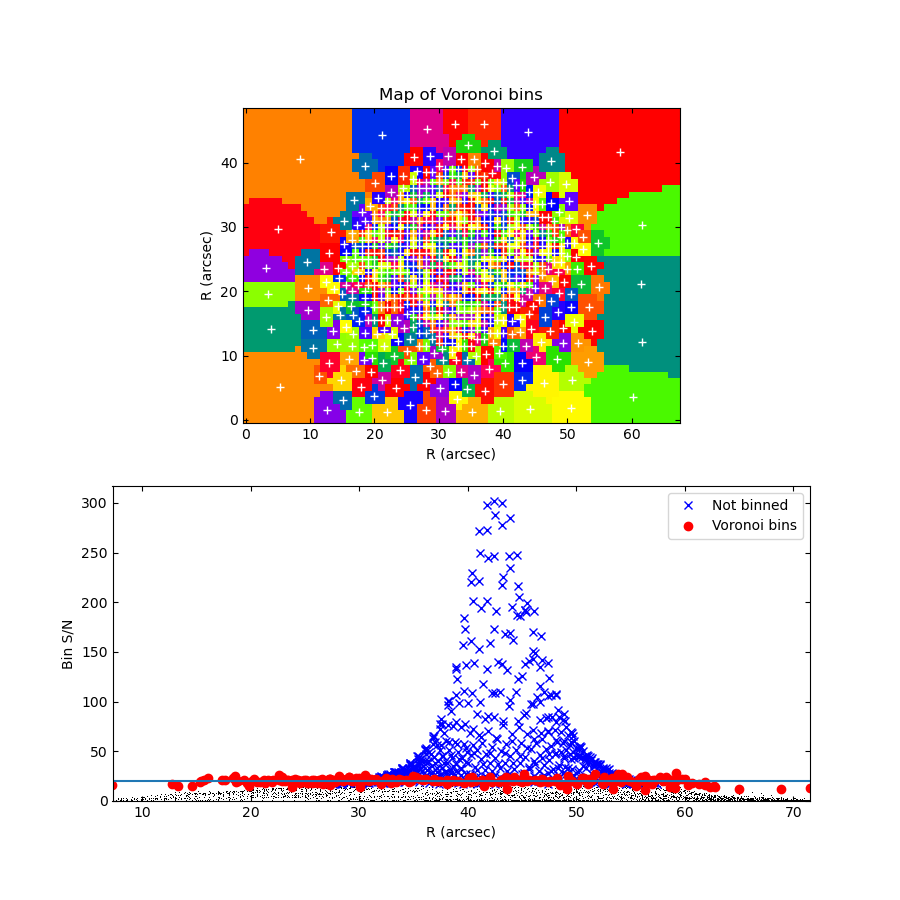

Total number of bin: 3332
After Voronoi binning: 841
1-pixel bin ratio: 69.32%


In [4]:
# Voronoi 2D binning
targetSN = 20.0

fig, ax = plt.subplots(figsize=(9,9))
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, sig, noi, targetSN, plot=1, quiet=1)
# plt.savefig(dir_vbin+'vbin2.png', dpi=300)
# plt.close()

uniq_val, uniq_ind, uniq_cnt = np.unique(binNum, return_index=True, return_counts=True) 
print(f'Total number of bin: {len(x):d}')
print(f'After Voronoi binning: {len(uniq_val):d}')
print(f'1-pixel bin ratio: {100.0*np.sum(uniq_cnt == 1)/len(uniq_val):.2f}%')

ix, iy = x.astype(int), y.astype(int)
data_vbin = np.zeros((d_sci.shape[1], d_sci.shape[2]))
for i in np.arange(len(binNum)):
	data_vbin[iy[i], ix[i]] = binNum[i]

In [5]:
edge_cnd = ((x == x[0]) | (x == x[-1]) | (y == y[0]) | (y == y[-1]))
binNum_edge = np.unique(binNum[edge_cnd])
print(binNum_edge)
print(len(binNum_edge))

[208 220 226 259 278 287 347 409 436 598 621 630 641 650 664 716 740 778
 802 813 829 836 837 838 839 840]
26


In [6]:
data_vbin2 = copy.deepcopy(data_vbin)
for i in np.arange(len(binNum_edge)):
    data_vbin2[data_vbin2 == binNum_edge[i]] = -99
data_vbin2[0,:] = -99
data_vbin2[:,0] = -99
data_vbin2[-1,:] = -99
data_vbin2[:,-1] = -99

<IPython.core.display.Javascript object>


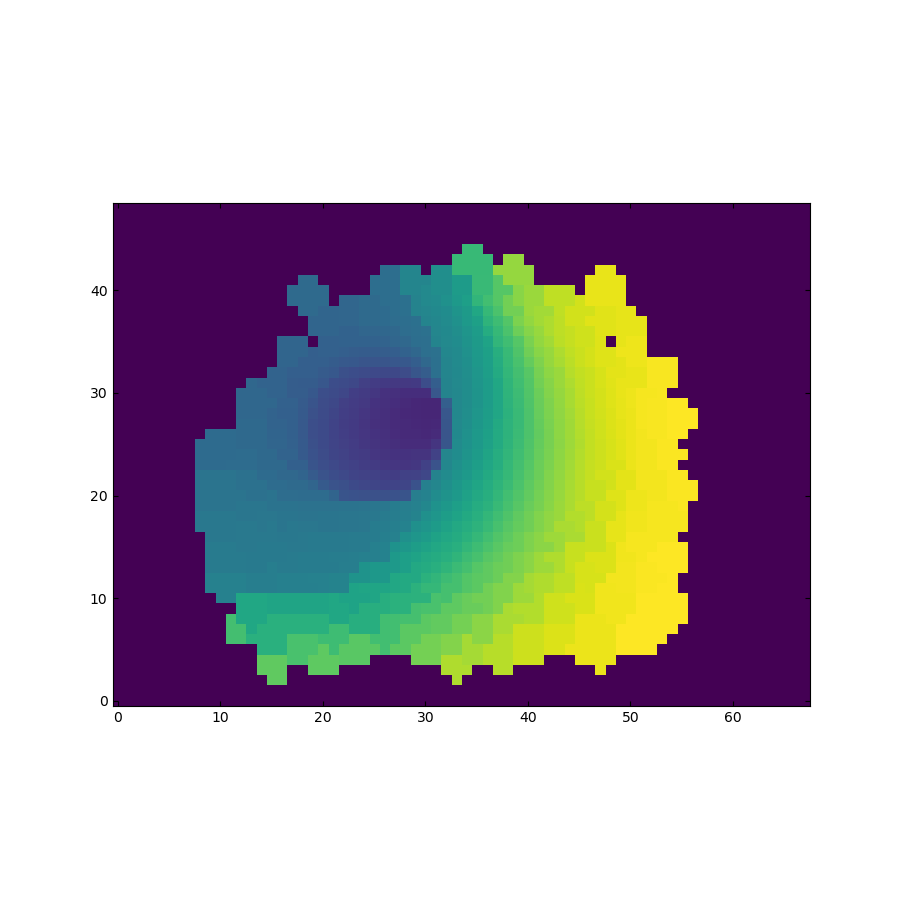

In [7]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(data_vbin2, origin='lower')

In [8]:
N_iter = 2
trial = 0
while (trial < N_iter):
    d99 = (data_vbin2 == -99.)
    y99, x99 = np.argwhere(d99).T
    for ypix, xpix in np.argwhere(d99):
        pix_dist = np.sqrt((xpix-x99)**2 + (ypix-y99)**2)
        edge_cnd = ((xpix == 0) | (xpix == x99[-1]) | (ypix == 0) | (ypix == y99[-1]))
        if ((np.sort(pix_dist)[3] > 1.) & (edge_cnd == False)):
#             print(f"({int(xpix):d},{int(ypix):d})")
            data_vbin2[ypix, xpix] = 99.9
    trial += 1

<IPython.core.display.Javascript object>


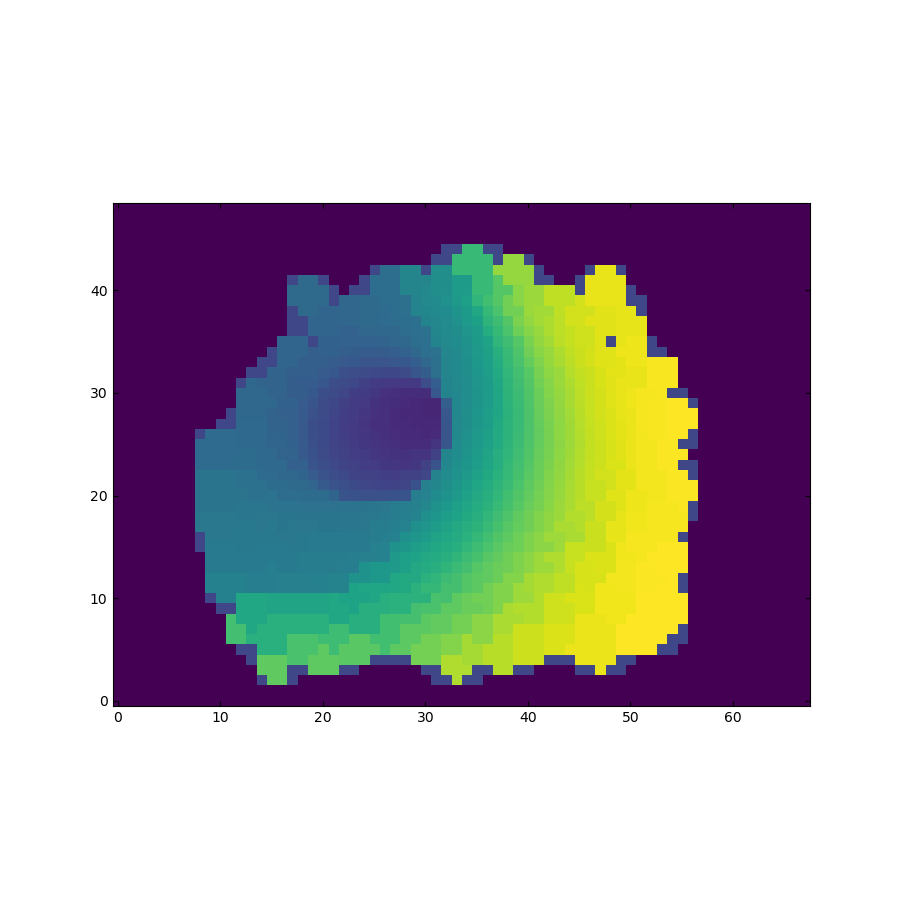

In [9]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(data_vbin2, origin='lower')

In [10]:
# Writing & reloading the input text file
d00 = (data_vbin2 >= 0)

f = open(dir_vbin+'vorbin_input2.txt', 'w')
for y, x in np.argwhere(d00):
    sig, noi = 0., 0.
    for w in np.arange(len(wav_range)):
    	sig_sum = np.sum(d_sci_sb[spx_range[w,0]:spx_range[w,1], y, x], axis=0)
    	noi_sum = np.sum(d_var_sb[spx_range[w,0]:spx_range[w,1], y, x], axis=0)
    	sig += np.maximum(0, sig_sum)
    	noi += np.where(noi_sum > 0., noi_sum, 1.0e-6)
    f.write(f"{x:.2f}    {y:.2f}    {sig:.3e}    {np.sqrt(noi):.3e}\n")
f.close()

x, y, sig, noi = np.loadtxt(dir_vbin+'vorbin_input2.txt').T       

<IPython.core.display.Javascript object>


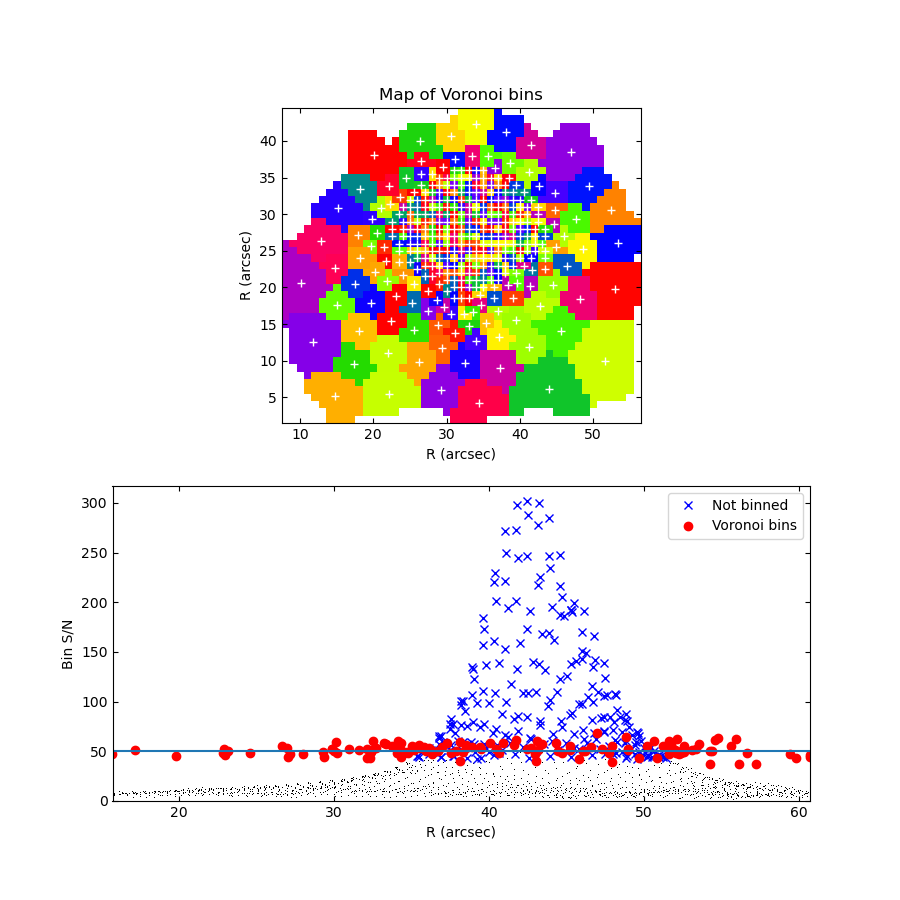

Total number of bin: 1738
After Voronoi binning: 367
1-pixel bin ratio: 63.49%


In [11]:
# Voronoi 2D binning
targetSN = 50.0

fig, ax = plt.subplots(figsize=(9,9))
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, sig, noi, targetSN, plot=1, quiet=1)
# plt.savefig(dir_vbin+'vbin2.png', dpi=300)
# plt.close()

uniq_val, uniq_ind, uniq_cnt = np.unique(binNum, return_index=True, return_counts=True) 
print(f'Total number of bin: {len(x):d}')
print(f'After Voronoi binning: {len(uniq_val):d}')
print(f'1-pixel bin ratio: {100.0*np.sum(uniq_cnt == 1)/len(uniq_val):.2f}%')

In [12]:
# Saving the results
np.savetxt(dir_vbin+'vorbin_output.txt', np.column_stack([x, y, binNum, sn[binNum], nPixels[binNum], scale[binNum]]),
           fmt='%4i  %4i  %4i  %6.2f  %4i  %6.2f')

ix, iy = x.astype(int), y.astype(int)
dat2_vbin = np.zeros((d_sci.shape[1], d_sci.shape[2]))
dat2_vbin[:, :] = -99
for i in np.arange(len(binNum)):
	dat2_vbin[iy[i], ix[i]] = binNum[i]
fits.writeto(dir_vbin+'vbin.fits', dat2_vbin, overwrite=True)